A solution:

KNO3 0.15841 moles in 1L of A mix =>
conc of KNO3 = 0.158 mol/L =>
moles of KNO3 in 10mL = 0.00158 =>
Assuming main tank capacity as 10L,
increase in the concentration of K in the main tank is 0.000158mol/L = 6.18 ppm.

For 1ml, increase in K is 0.618 ppm.

For N, 1ml results in increase of 1.1424 ppm.

B Solution:

For N, 1ml => 0.591 ppm

For P, 0.38812 ppm

For K, 1.517 ppm

If tank capacity is x, change these to val * 10 / x.

In [4]:
from math import gcd

In [5]:
def find_npkratio(n, p, k):
    n = int(n)
    p = int(p)
    k = int(k)
    # Find the greatest common divisor (GCD) of n, p, and k
    gcd_npk = gcd(gcd(n, p), k)

    # Divide each element by the GCD to get the ratio
    n_ratio = n // gcd_npk
    p_ratio = p // gcd_npk
    k_ratio = k // gcd_npk

    return (n_ratio, p_ratio, k_ratio)

In [2]:
pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [1]:
!pip install 'shimmy>=0.2.1'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.3/954.3 kB 9.7 MB/s eta 0:00:00


In [ ]:
import gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env


class GreenhouseEnv(gym.Env):
    def __init__(self):
        super(GreenhouseEnv, self).__init__()
        # State space: N, P, K levels and pH
        self.observation_space = gym.spaces.Box(low=np.array([0, 0, 0, 3]), high=np.array([100, 100, 100, 11]), dtype=np.float32)
        # Action space: 5 actions and 11 discrete amounts (0, 10, 20, ..., 100 ml)
        self.action_space = gym.spaces.MultiDiscrete([4, 11])
        self.state = None  # Initial N, P, K, pH levels will be set in reset()

    def step(self, action):
        N_A = 1.1424
        K_A = 0.618
        N_B = 0.591
        P_B = 0.38812
        K_B = 1.517
        conc = 10**(-3) # Concentration of acid used (To be Updated)
        vol_of_tank = 10 # To be Updated

        # Extract discrete action and amount (amount is in steps of 10 ml)
        discrete_action = int(action[0])
        amount_step = int(action[1])
        amount = amount_step * 10

        # Initialize inputs
        a_solution = b_solution = acid_input = 0

        # Perform the action
        if discrete_action == 1:
            self.state[0] += amount * N_A
            self.state[2] += amount * K_A
            a_solution = amount

        elif discrete_action == 2:
            self.state[0] += amount * N_B # To be Updated
            self.state[1] += amount * P_B
            self.state[2] += amount * K_B
            b_solution = amount

        elif discrete_action == 3:
            curr_conc = 10**(-self.state[3])
            new_conc = curr_conc +  (conc * amount / vol_of_tank)
            pH = -1*np.log10(new_conc)
            self.state[3] = pH  # Increase pH by adding acid
            acid_input = amount

        # elif discrete_action == 4:
        #     self.state[3] += amount * 0.01  # Decrease pH by adding base

        # Clip the state to stay within valid ranges
        self.state = np.clip(self.state, [0, 0, 0, 0], [100, 100, 100, 14])

        # Calculate reward
        reward = -(a_solution + b_solution + acid_input)

        # Check if N, P, K levels are within optimal range
        if 40 < self.state[0] < 60 and 30 < self.state[1] < 50 and 35 < self.state[2] < 55 and 5.5 < self.state[3] < 7.0:
            reward += 50
        if 40 < self.state[0] < 60 :
            reward += 5
        if 30 < self.state[1] < 50 :
            reward += 5
        if 35 < self.state[2] < 55 :
            reward += 5
        if 5.5 < self.state[3] < 7.0 :
            reward += 10

        # Penalty for extreme NPK levels
        if self.state[0] < 20 or self.state[0] > 80 or self.state[1] < 20 or self.state[1] > 70 or self.state[2] < 25 or self.state[2] > 75 or self.state[3] < 5.5 or self.state[3] > 7.0:
            reward -= 30

        # I found that the optimal NPK ratio is 3:1:2
        a,b,c = find_npkratio(self.state[0], self.state[1], self.state[2])
        NPK_ratio_penalty = (a - 3)**2 + (b - 1)**2 + (c - 2)**2
        reward -= NPK_ratio_penalty

        if a==3 and b==1 and c==2: # Ratio can be maintained even if doesn't have enough nutrients. So, I have considered less reward.
            reward += 10

        done = 40 < self.state[0] < 60 and 30 < self.state[1] < 50 and 35 < self.state[2] < 55 and 5.5 < self.state[3] < 7.0
        return self.state, reward, done, {}

    def reset(self):
        # Randomize initial state within a realistic range
        self.state = np.array([
            np.random.uniform(15, 85),  # N level
            np.random.uniform(15, 75),  # P level
            np.random.uniform(20, 80),  # K level
            np.random.uniform(4.0, 10.0) # pH level
        ])
        return self.state

    def render(self, mode='human'):
        pass

env = make_vec_env(lambda: GreenhouseEnv(), n_envs=1)

# Define the PPO model
model = PPO('MlpPolicy', env, verbose=1)

# Train the model
model.learn(total_timesteps=30000)

# Test the trained agent
obs = env.reset()
for _ in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Using cuda device
-----------------------------
| time/              |      |
|    fps             | 448  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 335         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009557802 |
|    clip_fraction        | 0.097       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.78       |
|    explained_variance   | 9.89e-06    |
|    learning_rate        | 0.0003      |
|    loss                 | 7.25e+05    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0103     |
|    value_loss           | 9.15e+07    |
-----------------------------------------
----------------

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Using cuda device
-----------------------------
| time/              |      |
|    fps             | 267  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 267         |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011395221 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.78       |
|    explained_variance   | -1.05e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 7.11e+05    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.015      |
|    value_loss           | 1.24e+07    |
-----------------------------------------
----------------

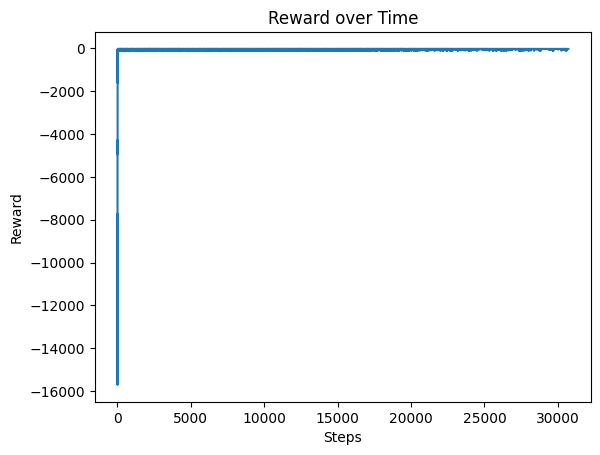

In [11]:
import gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

class GreenhouseEnv(gym.Env):
    def __init__(self):
        super(GreenhouseEnv, self).__init__()
        # State space: N, P, K levels and pH
        self.observation_space = gym.spaces.Box(low=np.array([0, 0, 0, 3]), high=np.array([100, 100, 100, 11]), dtype=np.float32)
        # Action space: 5 actions and 11 discrete amounts (0, 10, 20, ..., 100 ml)
        self.action_space = gym.spaces.MultiDiscrete([4, 11])
        self.state = None  # Initial N, P, K, pH levels will be set in reset()

    def step(self, action):
        N_A = 1.1424
        K_A = 0.618
        N_B = 0.591
        P_B = 0.38812
        K_B = 1.517
        conc = 10**(-3) # Concentration of acid used (To be Updated)
        vol_of_tank = 10 # To be Updated

        # Extract discrete action and amount (amount is in steps of 10 ml)
        discrete_action = int(action[0])
        amount_step = int(action[1])
        amount = amount_step * 10

        # Initialize inputs
        a_solution = b_solution = acid_input = 0

        # Perform the action
        if discrete_action == 1:
            self.state[0] += amount * N_A
            self.state[2] += amount * K_A
            a_solution = amount

        elif discrete_action == 2:
            self.state[0] += amount * N_B # To be Updated
            self.state[1] += amount * P_B
            self.state[2] += amount * K_B
            b_solution = amount

        elif discrete_action == 3:
            curr_conc = 10**(-self.state[3])
            new_conc = curr_conc +  (conc * amount / vol_of_tank)
            pH = -1*np.log10(new_conc)
            self.state[3] = pH  # Increase pH by adding acid
            acid_input = amount

        # elif discrete_action == 4:
        #     self.state[3] += amount * 0.01  # Decrease pH by adding base

        # Clip the state to stay within valid ranges
        self.state = np.clip(self.state, [0, 0, 0, 0], [100, 100, 100, 14])

        # Calculate reward
        reward = -(a_solution + b_solution + acid_input)

        # Check if N, P, K levels are within optimal range
        if 40 < self.state[0] < 60 and 30 < self.state[1] < 50 and 35 < self.state[2] < 55 and 5.5 < self.state[3] < 7.0:
            reward += 50
        if 40 < self.state[0] < 60 :
            reward += 5
        if 30 < self.state[1] < 50 :
            reward += 5
        if 35 < self.state[2] < 55 :
            reward += 5
        if 5.5 < self.state[3] < 7.0 :
            reward += 10

        # Penalty for extreme NPK levels
        if self.state[0] < 20 or self.state[0] > 80 or self.state[1] < 20 or self.state[1] > 70 or self.state[2] < 25 or self.state[2] > 75 or self.state[3] < 5.5 or self.state[3] > 7.0:
            reward -= 30

        # I found that the optimal NPK ratio is 3:1:2
        a,b,c = find_npkratio(self.state[0], self.state[1], self.state[2])
        NPK_ratio_penalty = (a - 3)**2 + (b - 1)**2 + (c - 2)**2
        reward -= NPK_ratio_penalty

        if a==3 and b==1 and c==2: # Ratio can be maintained even if doesn't have enough nutrients. So, I have considered less reward.
            reward += 10

        done = 40 < self.state[0] < 60 and 30 < self.state[1] < 50 and 35 < self.state[2] < 55 and 5.5 < self.state[3] < 7.0
        return self.state, reward, done, {}

    def reset(self):
        # Randomize initial state within a realistic range
        self.state = np.array([
            np.random.uniform(15, 85),  # N level
            np.random.uniform(15, 75),  # P level
            np.random.uniform(20, 80),  # K level
            np.random.uniform(4.0, 10.0) # pH level
        ])
        return self.state

    def render(self, mode='human'):
        pass

class RewardLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggerCallback, self).__init__(verbose)
        self.rewards = []

    def _on_step(self):
        self.rewards.append(self.locals['rewards'])
        return True

env = make_vec_env(lambda: GreenhouseEnv(), n_envs=1)

# Define the PPO model with modified hyperparameters
model = PPO(
    'MlpPolicy',
    env,
    verbose=1,
    learning_rate=3e-4,  # Reduce learning rate
    n_steps=2048,        # Increase number of steps
    batch_size=64,       # Decrease batch size
    n_epochs=10,         # Increase number of epochs
    gamma=0.99,          # Discount factor
    gae_lambda=0.95,     # GAE lambda
    clip_range=0.2,      # Clip range
    ent_coef=0.01,       # Entropy coefficient
    vf_coef=0.5,         # Value function coefficient
    max_grad_norm=0.5    # Max gradient norm
)

# Train the model with the custom callback
reward_logger = RewardLoggerCallback()
model.learn(total_timesteps=30000, callback=reward_logger)

# Calculate average reward
average_reward = np.mean(reward_logger.rewards)
print(f'Average Reward: {average_reward}')

# Plot the rewards
plt.plot(reward_logger.rewards)
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title('Reward over Time')
plt.show()

